## 1. Load conflict data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils as ut
from params import *

# Load conflict data
df_conflict = pd.read_csv('../input/cleaned/df_conflict.csv')
df_conflict = df_conflict[['isocode', 'period', 'log_best', 'population', 'since_anyviolence']]
df_conflict.head()

,isocode,period,log_best,population,since_anyviolence
0,AFG,198901,6.572283,11726646.0,0
1,AFG,198902,5.081404,11755987.0,0
2,AFG,198903,7.464510,11785402.0,0
3,AFG,198904,6.204558,11814890.0,0
4,AFG,198905,6.120297,11844452.0,0


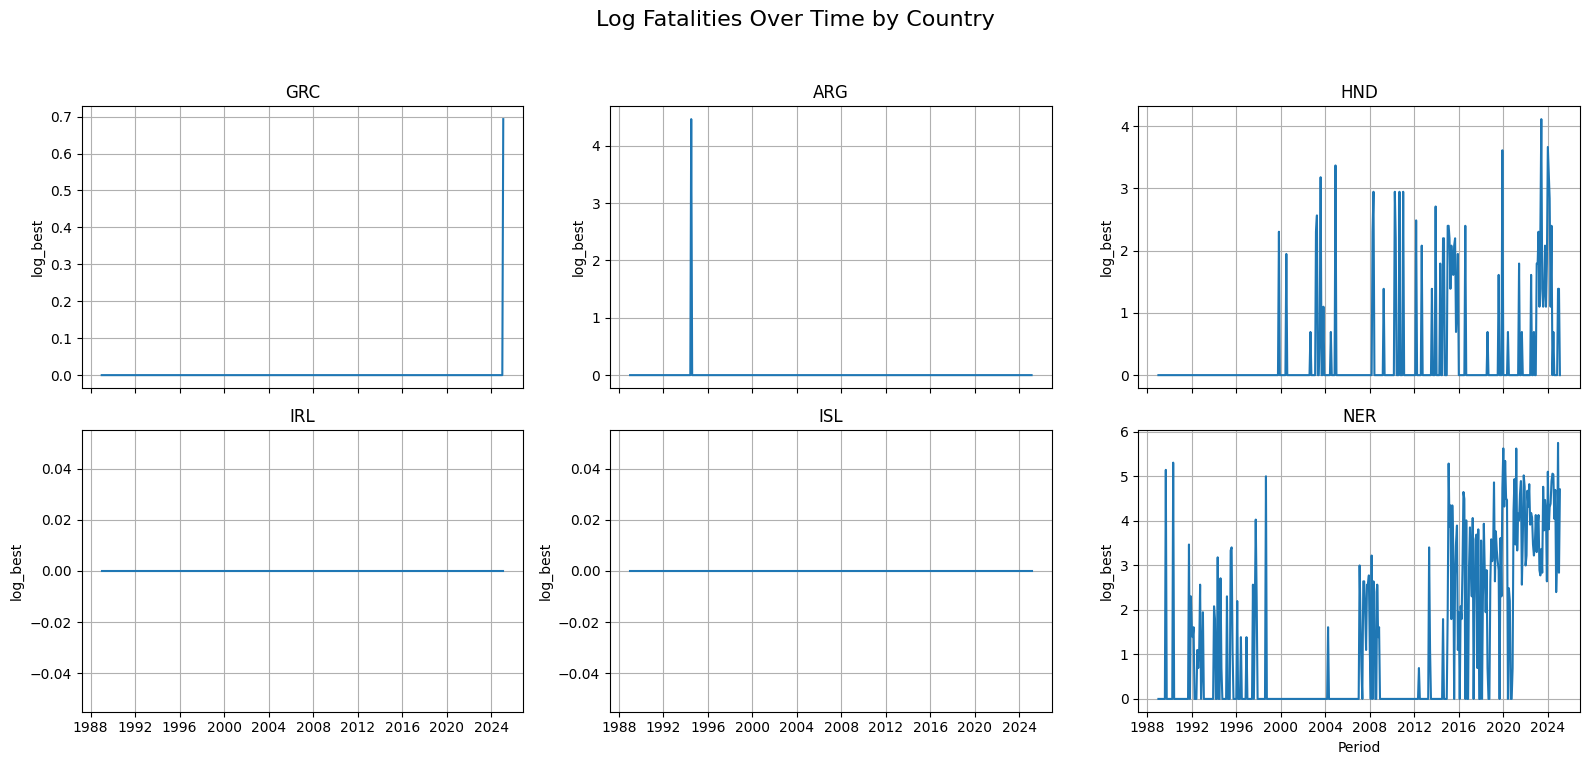

In [2]:
# Selected countries
selected_countries = ["GRC", "ARG", "HND", "IRL", "ISL", "NER"]
df_plot = df_conflict.copy()
df_plot['period_dt'] = pd.to_datetime(df_plot['period'].astype(str), format='%Y%m')

# Filter for selected countries
filtered_df = df_plot[df_plot['isocode'].isin(selected_countries)]
filtered_df = filtered_df.sort_values(['isocode', 'period_dt'])

# Create 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True)
axes = axes.flatten()  # Flatten 2D array to make indexing easier
for i, country in enumerate(selected_countries):
    ax = axes[i]
    country_df = filtered_df[filtered_df['isocode'] == country]
    ax.plot(country_df['period_dt'], country_df['log_best'], label=country, color='tab:blue')
    ax.set_title(f"{country}")
    ax.set_ylabel("log_best")
    ax.grid(True)

for j in range(len(selected_countries), len(axes)):
    axes[j].set_visible(False)
plt.suptitle("Log Fatalities Over Time by Country", fontsize=16)
plt.xlabel("Period")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Load forecasts to match

In [3]:
df_forecast = pd.read_csv(output_path + 'forecasts/rf_regressor_20250326.csv')
df_forecast.head()

,isocode,period,log_best,log_best_hat
0,AFG,199405,5.003946,5.299536
1,AFG,199406,5.976351,5.854654
2,AFG,199407,5.236442,5.180276
3,AFG,199408,5.624018,5.464087
4,AFG,199409,6.182085,5.866209


## Load treatment

In [4]:
# For LDA treatment
df_treatment = pd.read_csv(output_path + 'treatment/df_treatment_lda.csv')

# For Mona-based treatment
#df_treatment = pd.read_csv(cleaned_input_path + 'df_mistral_topics.csv')
#df_treatment['treat1']   = np.where(df_treatment['mona_start'] == 0, 1, 0)
#df_treatment['treat2']   = np.where(df_treatment['mona_start'] >= 0, 1, 0)
#df_treatment = df_treatment[['isocode', 'period', 'treat1', 'treat2']]
df_treatment.head()

,isocode,period,continent,treat_top_10,treat_top_50,treat_top_100
0,AFG,198901,Asia,0.0,0.0,0.0
1,AFG,198902,Asia,0.0,0.0,0.0
2,AFG,198903,Asia,0.0,0.0,0.0
3,AFG,198904,Asia,0.0,0.0,0.0
4,AFG,198905,Asia,0.0,0.0,0.0


## Merge dfs

In [5]:
# Merge treatment and forecast data
# ================================================================================
df_merged = df_treatment.merge(df_forecast, on=['isocode', 'period'], how='left')
df_merged.dropna(inplace=True)

# Time period factorization
# ================================================================================
df_merged['period_t'] = df_merged.groupby('isocode')["period"].transform(lambda x: pd.factorize(x, sort=True)[0])
df_merged

,isocode,period,continent,treat_top_10,treat_top_50,treat_top_100,log_best,log_best_hat,period_t
64,AFG,199405,Asia,0.0,0.0,0.0,5.003946,5.299536,0
65,AFG,199406,Asia,0.0,0.0,0.0,5.976351,5.854654,1
66,AFG,199407,Asia,0.0,0.0,0.0,5.236442,5.180276,2
67,AFG,199408,Asia,0.0,0.0,0.0,5.624018,5.464087,3
68,AFG,199409,Asia,0.0,0.0,0.0,6.182085,5.866209,4
...,...,...,...,...,...,...,...,...,...
84191,ZWE,202410,Africa,0.0,0.0,0.0,0.000000,0.000000,365
84192,ZWE,202411,Africa,0.0,0.0,0.0,0.000000,0.000000,366
84193,ZWE,202412,Africa,0.0,0.0,0.0,0.000000,0.000000,367
84194,ZWE,202501,Africa,0.0,0.0,0.0,0.000000,0.000000,368


## Local Projetions

In [6]:
outcome_var = 'log_best'
treatment_var = 'treat_top_100'


LP-DiD Event Study Estimates

+----+----------+------------+--------------+------------+------------+------------+------------+--------------+
|    | E-time   |   Estimate |   Std. Error |    t value |      P>|t| |   CI Lower |   CI Upper |         nobs |
+====+==========+============+==============+============+============+============+============+==============+
|  0 | pre18    |   0.152761 |     0.114556 |   1.333504 |   0.091183 |  -0.071769 |   0.377290 | 67546.000000 |
|  1 | pre17    |   0.125948 |     0.139732 |   0.901355 |   0.183700 |  -0.147926 |   0.399822 | 67738.000000 |
|  2 | pre16    |   0.096648 |     0.122059 |   0.791814 |   0.214234 |  -0.142588 |   0.335884 | 67930.000000 |
|  3 | pre15    |   0.134931 |     0.112759 |   1.196626 |   0.115726 |  -0.086078 |   0.355939 | 68122.000000 |
|  4 | pre14    |   0.172672 |     0.095912 |   1.800329 |   0.035904 |  -0.015314 |   0.360659 | 68314.000000 |
|  5 | pre13    |   0.163484 |     0.083283 |   1.963006 |   0.02

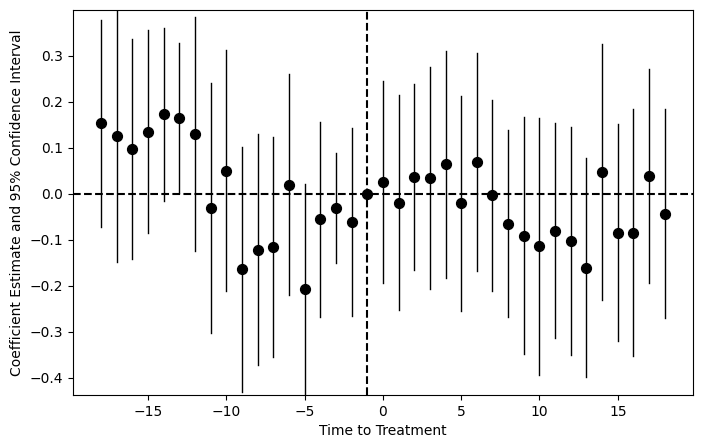

In [7]:
from causalpanel.lpdid.lpdid import lpdid, plot_lpdid

df_lpdid = df_merged.copy()
df_lpdid['isocode_t'] = pd.factorize(df_lpdid['isocode'])[0] + 1  # start from 1 instead of 0
df_lpdid = df_lpdid.sort_values(['isocode', 'period'])  # make sure data is sorted correctly
df_lpdid['period_t'] = df_lpdid.groupby('isocode').cumcount() + 1

results = lpdid(df_lpdid, outcome_var, 'period_t', 'isocode_t', treatment_var, 18, 18)
plot_lpdid(results['coeftable'])

## Generate Windows

In [8]:
from causalpanel.preprocessing.window_generator import WindowGenerator

wg = WindowGenerator(DataFrame = df_merged,
                     unit_column = 'isocode',
                     time_column = 'period_t',
                     treatment_column = treatment_var,
                     matching_column = 'log_best_hat', #['populationwb', 'uncertainty_index', 'past60', 'childmortality'],
                     frame_size = frame_size[0],
                     buffer_size=buffer_size)
wg.gen_treatment_windows(buffer_treated_windows=False)
print('Size of wg dataframe: ', wg.treated_windows.shape)
wg.treated_windows

Size of wg dataframe:  (3219, 16)


,isocode,period,continent,treat_top_10,treat_top_50,treat_top_100,log_best,log_best_hat,period_t,max_time_by_unit,since_treatment,until_treatment,since_treatment_1,until_treatment_-1,window_id,window_t
0,AFG,201905,Asia,0.0,0.0,0.0,7.942007,7.851496,300,369,301,18.0,300.0,17.0,0.282615,-18
1,AFG,201906,Asia,0.0,0.0,0.0,7.913887,7.885502,301,369,302,17.0,301.0,16.0,0.282615,-17
2,AFG,201907,Asia,0.0,0.0,0.0,8.248267,8.109707,302,369,303,16.0,302.0,15.0,0.282615,-16
3,AFG,201908,Asia,0.0,0.0,0.0,7.956827,7.782964,303,369,304,15.0,303.0,14.0,0.282615,-15
4,AFG,201909,Asia,0.0,0.0,0.0,8.168203,7.975466,304,369,305,14.0,304.0,13.0,0.282615,-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214,ZMB,202310,Africa,0.0,0.0,0.0,0.000000,0.045951,353,369,14,NaN,13.0,NaN,0.900366,14
3215,ZMB,202311,Africa,0.0,0.0,0.0,0.000000,0.028904,354,369,15,NaN,14.0,NaN,0.900366,15
3216,ZMB,202312,Africa,0.0,0.0,0.0,0.000000,0.055413,355,369,16,NaN,15.0,NaN,0.900366,16
3217,ZMB,202401,Africa,0.0,0.0,0.0,0.000000,0.053181,356,369,17,NaN,16.0,NaN,0.900366,17


In [9]:
wg.gen_control_windows(buffer_size=buffer_size, 
                       k=5,   # 5 control neighbors per treated observation
                       d=0.1, # The maximum propensity score distance between a treated observation and its corresponding untreated observation.
                       t=10,  # Can use a control observation up to 10 times.
                       )
wg.combine_groups() # this combines wg.treated_windows and wg.control_windows in to wg.windows.
wg.windows

,isocode,period,continent,treat_top_10,treat_top_50,treat_top_100,log_best,log_best_hat,period_t,max_time_by_unit,since_treatment,until_treatment,since_treatment_1,until_treatment_-1,window_id,window_t,treated
0,AFG,201905,Asia,0.0,0.0,0.0,7.942007,7.851496,300,369,301,18.0,300.0,17.0,0,-18,1
1,AFG,201906,Asia,0.0,0.0,0.0,7.913887,7.885502,301,369,302,17.0,301.0,16.0,0,-17,1
2,AFG,201907,Asia,0.0,0.0,0.0,8.248267,8.109707,302,369,303,16.0,302.0,15.0,0,-16,1
3,AFG,201908,Asia,0.0,0.0,0.0,7.956827,7.782964,303,369,304,15.0,303.0,14.0,0,-15,1
4,AFG,201909,Asia,0.0,0.0,0.0,8.168203,7.975466,304,369,305,14.0,304.0,13.0,0,-14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19309,KIR,202306,Oceania,0.0,0.0,0.0,0.000000,0.000000,349,369,350,NaN,349.0,NaN,521,14,0
19310,KIR,202307,Oceania,0.0,0.0,0.0,0.000000,0.000000,350,369,351,NaN,350.0,NaN,521,15,0
19311,KIR,202308,Oceania,0.0,0.0,0.0,0.000000,0.000000,351,369,352,NaN,351.0,NaN,521,16,0
19312,KIR,202309,Oceania,0.0,0.0,0.0,0.000000,0.000000,352,369,353,NaN,352.0,NaN,521,17,0


In [10]:
df_clean = wg.windows.copy()
df_clean = df_clean[["isocode", "period_t", treatment_var, "log_best", "window_id", "window_t", "treated"]]
df_clean

,isocode,period_t,treat_top_100,log_best,window_id,window_t,treated
0,AFG,300,0.0,7.942007,0,-18,1
1,AFG,301,0.0,7.913887,0,-17,1
2,AFG,302,0.0,8.248267,0,-16,1
3,AFG,303,0.0,7.956827,0,-15,1
4,AFG,304,0.0,8.168203,0,-14,1
...,...,...,...,...,...,...,...
19309,KIR,349,0.0,0.000000,521,14,0
19310,KIR,350,0.0,0.000000,521,15,0
19311,KIR,351,0.0,0.000000,521,16,0
19312,KIR,352,0.0,0.000000,521,17,0


## Diff-in-Diff Method

In [11]:
from causalpanel.csdid.att_gt import ATTGT

# Estimate ATTGT
dp = ATTGT(data = df_clean,
            yname = 'log_best',
            tname = 'window_t',
            idname = 'window_id',
            gname = 'treated',
            verbose = False)

dp.estimate_att_gt()


Group-Time Average Treatment Effects - Callaway and Sant'Anna (2021)

+---------+--------+------------+--------------+-------------------+---------------+-----------+
|   Group |   Time |   ATT(g,t) |   Std. Error |   [95% Pointwise  |   Conf. Band] | Signif.   |
+=========+========+============+==============+===================+===============+===========+
|       1 |    -17 |    -0.0192 |       0.094  |           -0.2034 |        0.1649 |           |
|       1 |    -16 |    -0.0239 |       0.0846 |           -0.1897 |        0.142  |           |
|       1 |    -15 |     0.0535 |       0.1271 |           -0.1957 |        0.3026 |           |
|       1 |    -14 |    -0.0092 |       0.0969 |           -0.199  |        0.1807 |           |
|       1 |    -13 |    -0.0552 |       0.0773 |           -0.2067 |        0.0964 |           |
|       1 |    -12 |     0.0468 |       0.0886 |           -0.1267 |        0.2204 |           |
|       1 |    -11 |     0.0961 |       0.0913 |        

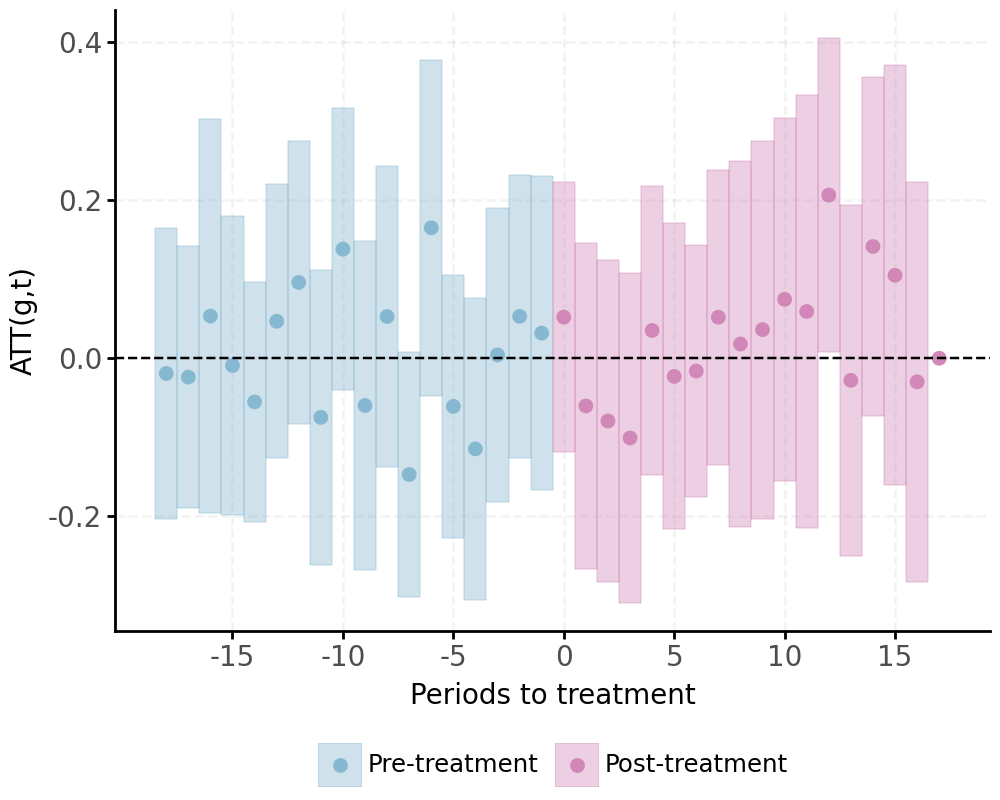

In [12]:
plots = dp.plot_att_gt(xgap=5, relative_time=True, title=False)